**IMPORT LIBRARY**

In [ ]:
#Import Library
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow import keras

**IMPORT DATASET**

Download dataset dari kaggle dengan menggunakan token

In [ ]:
! pip install -q kaggle # Install package Kaggle
from google.colab import files # Import modul upload file

files.upload() # Upload file dari lokal

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muttaqin1113","key":"18eacd5f46e5a81bede8a87737393069"}'}

In [ ]:
!mkdir ~/.kaggle # Membuat folder konfigurasi Kaggle
!cp kaggle.json ~/.kaggle/ # Menyalin file API key ke folder Kaggle
!chmod 600 ~/.kaggle/kaggle.json # Mengatur izin file
!kaggle datasets download -d muttaqin1113/face-skin-type # Download dataset Kaggle

Dataset URL: https://www.kaggle.com/datasets/muttaqin1113/face-skin-type
License(s): apache-2.0
  0% 0.00/56.0M [00:00<?, ?B/s]
100% 56.0M/56.0M [00:00<00:00, 963MB/s]


In [ ]:
# Ekstrak file zip dataset dan hapus file zip setelah diekstrak
!unzip -q /content/face-skin-type.zip \
  && rm /content/face-skin-type.zip

**SPLITTING FOLDER**

In [ ]:
!pip install split-folders

*Membagi dataset menjadi 70% TRAIN, 20% VALIDATION, 10% TEST*

In [ ]:
import splitfolders
input_folder='/content/skin2'

# Membagi dataset dengan rasio 70% train, 20% val, 10% test
splitfolders.ratio(input_folder, output="Skin Type",
                   seed=42, ratio=(.7,.2,.1),
                  group_prefix=None)

Copying files: 1735 files [00:00, 4966.58 files/s]


**IMAGE AUGMENTATION**

ImageDataGenerator dan mengintegrasikan augmentasi gambar karena keterbatasan ukuran data yang tersedia.

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  # Inisialisasi data generator untuk training dengan augmentasi
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 45,
                                   width_shift_range = 0.25,
                                   height_shift_range = 0.25,
                                   shear_range = 0.25,
                                   zoom_range = 0.5,
                                   fill_mode = 'nearest',
                                   horizontal_flip = True)
  # Membuat data generator dari folder training
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(299, 299),
                                                      shuffle = True)

  validation_datagen = ImageDataGenerator(rescale = 1./255)
  # Data generator untuk validasi tanpa augmentasi
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(299, 299),
                                                                shuffle=False)
  testing_datagen = ImageDataGenerator(rescale=1./255)
   # Data generator untuk testing
  testing_generator = testing_datagen.flow_from_directory(directory=TESTING_DIR,
                                                          batch_size=32,
                                                          class_mode='categorical',
                                                          target_size=(299, 299),
                                                          shuffle=False)

  return train_generator, validation_generator, testing_generator

In [ ]:
# Direktori dataset hasil split untuk training, validasi, dan testing
TRAINING_DIR = '/content/Skin Type/train'
VALIDATION_DIR = '/content/Skin Type/val'
TESTING_DIR = '/content/Skin Type/test'

In [ ]:
# Memanggil fungsi untuk membuat data generator dari direktori yang telah ditentukan
train_generator, validation_generator, testing_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 1211 images belonging to 4 classes.
Found 346 images belonging to 4 classes.
Found 176 images belonging to 4 classes.


In [ ]:
# Import fungsi untuk load dataset sebagai tf.data.Dataset
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Memuat dataset training sebagai tf.data.Dataset, dengan shuffle dan ukuran gambar 224x224
train_dataset = image_dataset_from_directory(TRAINING_DIR,
                                             shuffle=True,
                                             image_size=(299,299))

Found 1211 files belonging to 4 classes.


In [ ]:
# Mendapatkan nama-nama kelas dari dataset
class_names = train_dataset.class_names

# Menampilkan daftar nama kelas
print(class_names)

['berjerawat', 'berminyak', 'kering', 'normal']


**VISUALISASI DATASET**

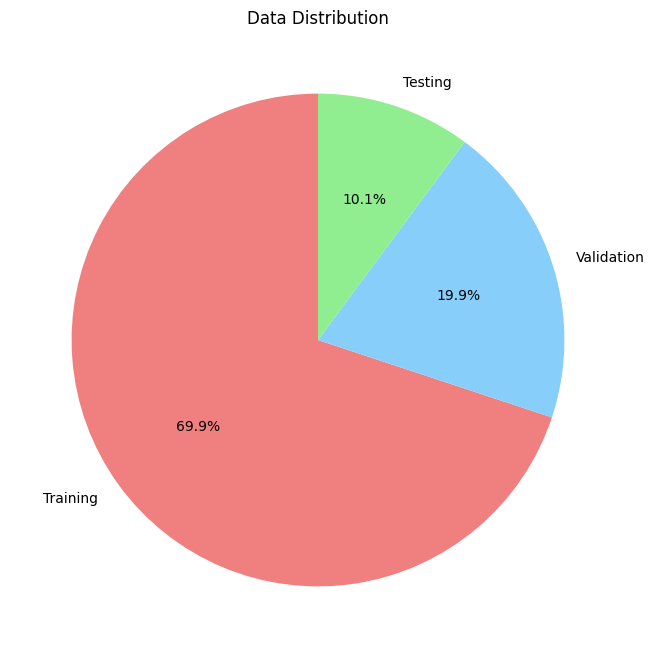

In [ ]:
def count_images_in_directory(directory):
    count = 0
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            count += len(os.listdir(label_path))
    return count

train_size = count_images_in_directory(TRAINING_DIR)
val_size = count_images_in_directory(VALIDATION_DIR)
test_size = count_images_in_directory(TESTING_DIR)

# Pie chart
sizes = [train_size, val_size, test_size]
labels_split = ['Training', 'Validation', 'Testing']
colors = ['lightcoral', 'lightskyblue', 'lightgreen']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels_split, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Data Distribution')
plt.show()

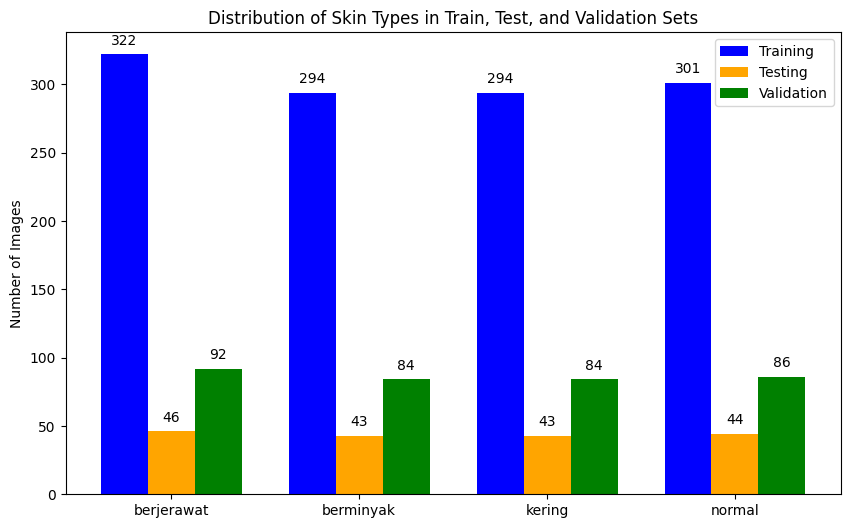

In [ ]:
def get_class_distribution(generator):
    return np.sum(generator.labels[:, None] == np.arange(len(generator.class_indices)), axis=0)

train_counts = get_class_distribution(train_generator)
val_counts = get_class_distribution(validation_generator)
test_counts = get_class_distribution(testing_generator)

# Bar chart
x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

train_bars = ax.bar(x - width, train_counts, width, label='Training', color='blue')
test_bars = ax.bar(x, test_counts, width, label='Testing', color='orange')
val_bars = ax.bar(x + width, val_counts, width, label='Validation', color='green')

ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Skin Types in Train, Test, and Validation Sets')
ax.legend()

for bars in [train_bars, test_bars, val_bars]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

plt.show()

TRANSFER LEARNING

Memanfaatkan Transfer Learning dengan MobileNetV2 untuk klasifikasi gambar, memanfaatkan pengetahuan pre-trained untuk mengenali dan mengkategorikan gambar secara akurat.

In [ ]:
# Import arsitektur MobileNetV2
from tensorflow.keras.applications import MobileNetV2

# Membuat model MobileNetV2 dengan bobot pre-trained
def create_pre_trained_model():
    pre_trained_model = MobileNetV2(
        input_shape=(224, 224, 3), # Ukuran input sesuai standar MobileNetV2
        include_top=False,         # Tidak menyertakan fully connected layer bawaan
        weights='imagenet'         # Menggunakan bobot dari ImageNet
    )

    # Membekukan seluruh layer agar tidak dilatih ulang
    for layer in pre_trained_model.layers:
        layer.trainable = False

    return pre_trained_model

In [ ]:
# Inisialisasi model pre-trained InceptionV3
pre_trained_model = create_pre_trained_model(local_weights_file)

# Menampilkan ringkasan arsitektur model
pre_trained_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Callback untuk menghentikan training jika akurasi dan val_akurasi >= 95%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.95 and logs.get('val_accuracy')>=0.95):
      print("\nReached 95.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
# Mengambil output dari layer terakhir ('out_relu') MobileNetV2
def output_of_last_layer(pre_trained_model):

    last_desired_layer = pre_trained_model.get_layer('out_relu')  # Ambil layer 'out_relu'
    print('Last layer output shape: ', last_desired_layer.output.shape)
    last_output = last_desired_layer.output
    print('Last layer output: ', last_output)

    return last_output

In [ ]:
# Menyimpan output dari layer 'out_relu' sebagai input untuk model lanjutan
last_output = output_of_last_layer(pre_trained_model)

In [ ]:
# Menambahkan layer baru di atas output dari model pre-trained
x = keras.layers.GlobalAveragePooling2D()(last_output)  # Pooling global dari fitur
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x) # Normalisasi batch
x = keras.layers.Dense (256, activation='relu')(x) # Fully connected layer dengan 256 unit
x = keras.layers.Dropout(0.5)(x) # Dropout untuk mencegah overfitting
x = keras.layers.Dense (4, activation='softmax')(x) # Output layer untuk 4 kelas (softmax)

# Membuat model akhir dengan input dari model pre-trained dan output dari layer baru
model2 = Model(pre_trained_model.input, x)
model2.summary()

# Compile model dengan Adam optimizer dan categorical crossentropy loss
model2.compile(optimizer=keras.optimizers.Adam(0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,592,068 (9.89 MB)

 Trainable params: 331,524 (1.26 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [ ]:
# Inisialisasi callback
callbacks = myCallback()

# Melatih model dengan data training dan validasi
history = model2.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks = [callbacks]
                    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
38/38 - 47s - 1s/step - accuracy: 0.3320 - loss: 1.9022 - val_accuracy: 0.5000 - val_loss: 1.2516
Epoch 2/100
38/38 - 25s - 658ms/step - accuracy: 0.4459 - loss: 1.4920 - val_accuracy: 0.5751 - val_loss: 1.0740
Epoch 3/100
38/38 - 17s - 445ms/step - accuracy: 0.5103 - loss: 1.3133 - val_accuracy: 0.6098 - val_loss: 0.9530
Epoch 4/100
38/38 - 18s - 472ms/step - accuracy: 0.5607 - loss: 1.1978 - val_accuracy: 0.6590 - val_loss: 0.8776
Epoch 5/100
38/38 - 17s - 443ms/step - accuracy: 0.5607 - loss: 1.1666 - val_accuracy: 0.6618 - val_loss: 0.8255
Epoch 6/100
38/38 - 18s - 484ms/step - accuracy: 0.5995 - loss: 1.1132 - val_accuracy: 0.6763 - val_loss: 0.7971
Epoch 7/100
38/38 - 17s - 448ms/step - accuracy: 0.6276 - loss: 1.0551 - val_accuracy: 0.6850 - val_loss: 0.7616
Epoch 8/100
38/38 - 17s - 441ms/step - accuracy: 0.6144 - loss: 1.0533 - val_accuracy: 0.6908 - val_loss: 0.7465
Epoch 9/100
38/38 - 18s - 468ms/step - accuracy: 0.6507 - loss: 0.9419 - val_accuracy: 0.7197 - val

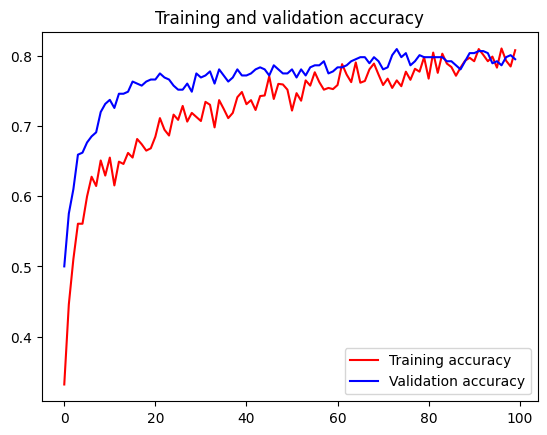

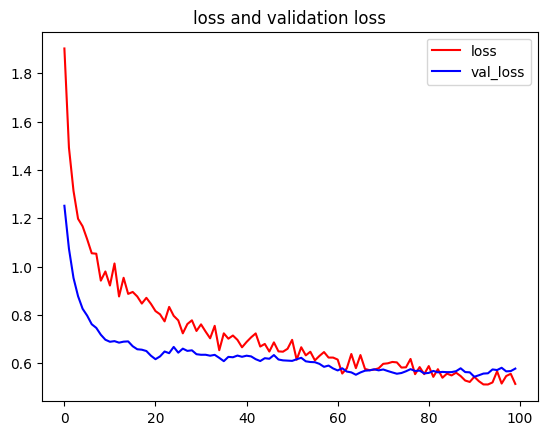

<Figure size 640x480 with 0 Axes>

In [ ]:
# Mengambil nilai akurasi dan loss dari history training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot akurasi training dan validasi
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

# Plot loss training dan validasi
plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('loss and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

**FINE TUNING**

Fine-tuning in transfer learning mengambil model cerdas yang sudah mengetahui banyak hal dan memberinya sedikit pelatihan tambahan sehingga menjadi sangat baik dalam tugas tertentu.

In [ ]:
pre_trained_model.trainable = True # Mengaktifkan kembali seluruh layer pre-trained untuk dilatih ulang

# Compile ulang model dengan learning rate kecil agar fine-tuning stabil
model2.compile(
    optimizer=keras.optimizers.Adam(1e-5),
                loss = keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics = ['accuracy']
)

# Melatih ulang seluruh model (fine-tuning)
model2.fit(train_generator,
           validation_data=validation_generator,
           epochs = 25)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 624ms/step - accuracy: 0.7741 - loss: 0.5791 - val_accuracy: 0.7948 - val_loss: 0.5747
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 441ms/step - accuracy: 0.7833 - loss: 0.6065 - val_accuracy: 0.7948 - val_loss: 0.5753
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 447ms/step - accuracy: 0.8086 - loss: 0.4882 - val_accuracy: 0.7977 - val_loss: 0.5742
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 447ms/step - accuracy: 0.7994 - loss: 0.5320 - val_accuracy: 0.8006 - val_loss: 0.5732
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 440ms/step - accuracy: 0.7948 - loss: 0.5353 - val_accuracy: 0.8006 - val_loss: 0.5737
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 464ms/step - accuracy: 0.7979 - loss: 0.5204 - val_accuracy: 0.7977 - val_loss: 0.5745
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 432ms/step - accuracy: 0.7662 - loss: 0.5694 - val_accuracy: 0.8006 - val_loss: 0.5709
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 437ms/step - accuracy: 0.7936 - loss: 0.5117 - val_accu

In [ ]:
test_loss, test_acc = model2.evaluate(testing_generator, verbose=2)
print(f"Final Test Accuracy: {test_acc:.2f}")

6/6 - 4s - 585ms/step - accuracy: 0.8295 - loss: 0.5311
Final Test Accuracy: 0.83


**CONFUSION MATRIX**

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 416ms/step


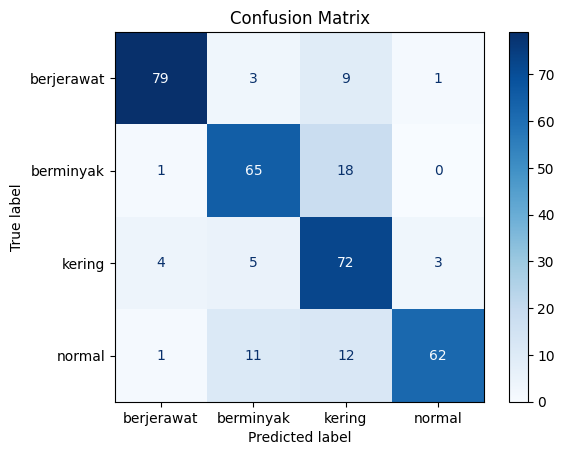

Classification Report:
              precision    recall  f1-score   support

  berjerawat       0.93      0.86      0.89        92
   berminyak       0.77      0.77      0.77        84
      kering       0.65      0.86      0.74        84
      normal       0.94      0.72      0.82        86

    accuracy                           0.80       346
   macro avg       0.82      0.80      0.81       346
weighted avg       0.83      0.80      0.81       346



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Y_pred_probs = model2.predict(validation_generator)
Y_pred = np.argmax(Y_pred_probs, axis=1)
Y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

cm = confusion_matrix(Y_true, Y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

print("Classification Report:")
print(classification_report(Y_true, Y_pred, target_names=class_labels))

**TESTING**

Saving kering.jpg to kering (3).jpg
Saving kering1.jpg to kering1 (3).jpg
Saving kering2.jpg to kering2 (2).jpg
Saving kering3.jpeg to kering3 (4).jpeg
Saving kering4.jpeg to kering4 (2).jpeg
Saving kering5.jpg to kering5 (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


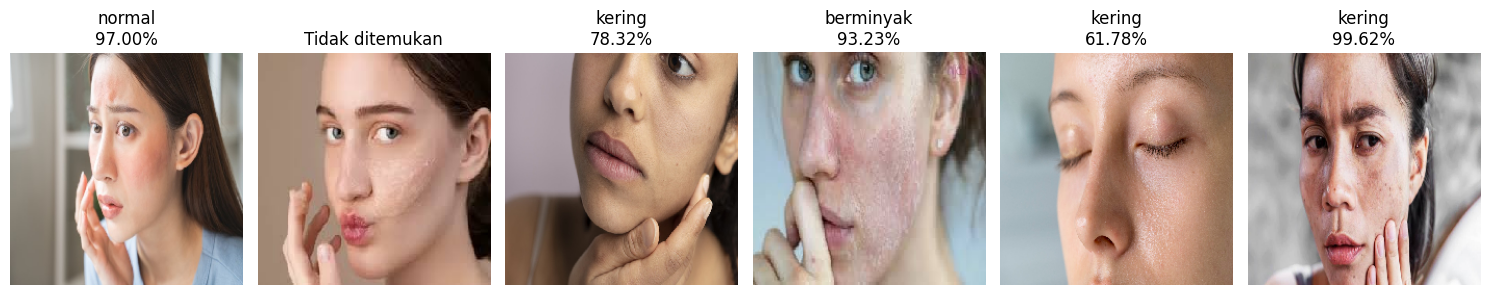


Gambar 1:
berjerawat: 1.20%
berminyak: 1.12%
kering: 0.68%
normal: 97.00%

Gambar 2:
berjerawat: 1.44%
berminyak: 11.59%
kering: 38.15%
normal: 48.82%

Gambar 3:
berjerawat: 6.12%
berminyak: 2.06%
kering: 78.32%
normal: 13.50%

Gambar 4:
berjerawat: 0.36%
berminyak: 93.23%
kering: 6.40%
normal: 0.01%

Gambar 5:
berjerawat: 0.35%
berminyak: 37.82%
kering: 61.78%
normal: 0.05%

Gambar 6:
berjerawat: 0.10%
berminyak: 0.26%
kering: 99.62%
normal: 0.02%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

labels = list(train_generator.class_indices.keys())
uploaded = files.upload()

imgs, preds, results = [], [], []

for fname in uploaded:
    img = image.load_img(fname, target_size=(224, 224))
    x = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))
    proba = model2.predict(x)[0]

    max_idx = np.argmax(proba)
    label = labels[max_idx] if proba[max_idx] >= 0.5 else "Tidak ditemukan"

    imgs.append(img)
    preds.append(proba)
    results.append(f"{label}\n{proba[max_idx]*100:.2f}%" if label != "Tidak ditemukan" else label)

plt.figure(figsize=(15, 6))
for i, img in enumerate(imgs):
    plt.subplot(1, len(imgs), i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(results[i])
plt.tight_layout()
plt.show()

# Cetak probabilitas detail
for i, proba in enumerate(preds):
    print(f"\nGambar {i+1}:")
    for label, p in zip(labels, proba):
        print(f"{label}: {p*100:.2f}%")